# Visualize ranges of fluxes across samples - REDS Recall
## Setup
### Import packages

In [1]:
import re
import textwrap
import warnings
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ensure_iterable,
    get_dirpath,
    read_cobra_model,
    show_versions,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    DEFAULT_PROTEOME_COMPARTMENT,
    EnzymeDilution,
    add_relaxation_budget,
    load_overlay_model,
    plot_correlations,
)
from rbc_gem_utils.visualization import cmap_map
from scipy.stats import spearmanr

plt.rcParams["font.family"] = "Arial"
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e-8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1e-08
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDSRecall"
grouped_data_key = 'Sample'

### Set variables for sample identification

In [21]:
# For sample IDs
sample_key = "SAMPLE ID"
donor_key = "PUBLIC RECALL DONOR ID"
time_key = "DAY"
timepoints = ["D10", "D23", "D42"]
genotypes = ["G6PD_V68M", "ATP11C_V972M"]
donor_re = re.compile(rf"(?P<donor>S(?P<num>\d+))")
time_re = re.compile(rf"(?P<time>{'|'.join(timepoints)})")
genotype_re = re.compile(rf"(?P<genotype>({'|'.join(genotypes)}))")

operations = "|".join([x.capitalize() for x in ["mean", "median"]])

operation_re = re.compile(r"(?P<op>" + operations + r")\_(?P<group>\w+)")
sample_id_re = re.compile(
    r"(?!" + operations + r")" + donor_re.pattern + r"\_" + time_re.pattern
)

### Set computation options

In [6]:
ftype = "xml"  # In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
run_computations = True  # Keep off to use previously computed results
overwrite = False  # Whether to allow overwriting of previous simulation results
verbose = True

# Objective reactions
objective_reactions = ["NaKt"] 
# Reactions that must have the capability to carry flux, sort for consistency
required_flux_reactions = [] # Add reactions to this list
required_flux_reactions = sorted(set(objective_reactions + required_flux_reactions))

#### Set prefixes/suffixes to expect

In [ ]:
enzyme_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.dilution"]
enzyme_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.metabolite"]
enzyme_met_suffix_total = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.total"]
comp_suffix = f"_{DEFAULT_PROTEOME_COMPARTMENT}"

### Set figure options

In [7]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [10]:
# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name / grouped_data_key)
pcfva_results_dirpath = (results_dirpath / "pcFVA" / "_".join(("REQ", *required_flux_reactions)) /  "_".join(("OBJ", *objective_reactions)))

# Objective reaction does not matter since correlations are computed
# based on min and max fluxes and abundance, which are obtained when optimum is 0.
corr_results_dirpath = results_dirpath / "correlations"
# Ensure directory  exists
corr_results_dirpath.mkdir(exist_ok=True, parents=True)

## Load RBC-GEM model

In [11]:
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

# Add relaxation budget to initial PC model to get names of relaxation reactions
add_relaxation_budget(pcmodel, 0, verbose=False)
pcmodel

Set parameter Username
Set parameter LicenseID to value 2664191
Academic license - for non-commercial use only - expires 2026-05-12


Name,RBC_GEM_PC
Memory address,14130e22150
Number of metabolites,10411
Number of reactions,19619
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load pcFVA generated results

In [12]:
# Test to see if results were recently generated in this run, otherwise load DataFrame of generated results
df_pcfva_all = pd.read_csv(
    pcfva_results_dirpath / f"{pcmodel.id}_All_FVAsols.zip",
    index_col=None,
)

df_pcfva_all

,model,reactions,optimum,min,max
0,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.00,0.0,0.0
1,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.50,0.0,0.0
2,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.90,0.0,0.0
3,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.99,0.0,0.0
4,RBC_GEM_PC_Mean_ATP11C_V972M_0,15KPGE1Ry,0.00,0.0,0.0
...,...,...,...,...,...
54755171,RBC_GEM_PC_S650_D42,ZN2_HCO3_SELNIt,0.99,0.0,0.0
54755172,RBC_GEM_PC_S650_D42,ZN2t,0.00,0.0,0.0
54755173,RBC_GEM_PC_S650_D42,ZN2t,0.50,0.0,0.0
54755174,RBC_GEM_PC_S650_D42,ZN2t,0.90,0.0,0.0


## Create DataFrame for visualization
### Get maximum reaction fluxes and associated abundance values
#### Define reactions that are always abundance-independent (no genes/proteins)

In [13]:
always_abundance_independent = [
    r.id for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
]
print(
    f"Number of reactions w/o genes, always abundance independent: {len(always_abundance_independent)}"
)
always_abundance_independent;

Number of reactions w/o genes, always abundance independent: 535


#### Get maximum reaction fluxes and flux ranges

In [14]:
rxns = model.reactions.list_attr("id")
df_max_flux_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
df_max_flux_per_model = df_max_flux_per_model.groupby(["model", "reactions", "optimum"])[["min", "max"]].agg(
    {
        "min": "min", # Minimum reaction flux per model
        "max": "max", # Maximum reaction flux per model
    }
)
# Address issues possibly caused by floating point precision, ideally a value that prevents any negative ranges
df_max_flux_per_model.loc[df_max_flux_per_model["max"] < df_max_flux_per_model["min"], ["max", "min"]] = [0, 0]
atol = COBRA_CONFIGURATION.tolerance
df_max_flux_per_model["max"] = df_max_flux_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model["min"] = df_max_flux_per_model["min"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model["range"] = df_max_flux_per_model["max"] - df_max_flux_per_model["min"]
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_flux_per_model[df_max_flux_per_model["range"] < 1e-9]

,,,min,max,range
model,reactions,optimum,,,


#### Get maximum "enzyme" abundances

In [15]:
rxns = pcmodel.reactions.query(
    lambda x: isinstance(x, EnzymeDilution) and x.id.endswith(f"{enzyme_met_suffix_total}{comp_suffix}")
).list_attr("id")
df_max_abundance_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
# Rename dilution reactions to match 
reaction_enzyme_map = {
    enzyme_rid: enzyme_rid.replace(
        f"{enzyme_rxn_prefix}{enzyme_met_prefix}", ""
    ).replace(
        f"{enzyme_met_suffix_total}{comp_suffix}", ""
    )
    for enzyme_rid in df_max_abundance_per_model["reactions"]
}
df_max_abundance_per_model["reactions"] = df_max_abundance_per_model["reactions"].replace(reaction_enzyme_map)
df_max_abundance_per_model = df_max_abundance_per_model.groupby(["model", "reactions", "optimum"])[["max"]].max()
# Address issues possibly caused by floating point precision, atol is ideally a value that prevents any negative ranges
atol = COBRA_CONFIGURATION.tolerance
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if x < 0 else x)
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_abundance_per_model = df_max_abundance_per_model.rename({"max": "abundance"}, axis=1)
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_abundance_per_model[(df_max_abundance_per_model < 0).any(axis=1)]

,,,abundance
model,reactions,optimum,


#### Merge DataFrames

In [16]:
df_data_all = pd.merge(
    df_max_flux_per_model,
    df_max_abundance_per_model,
    left_index=True,
    right_index=True,
    how="left",
)
df_data_all = df_data_all.reset_index(drop=False)
df_data_all

,model,reactions,optimum,min,max,range,abundance
0,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.00,0.0,0.0,0.0,NaN
1,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.50,0.0,0.0,0.0,NaN
2,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.90,0.0,0.0,0.0,NaN
3,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.99,0.0,0.0,0.0,NaN
4,RBC_GEM_PC_Mean_ATP11C_V972M_0,15KPGE1Ry,0.00,0.0,0.0,0.0,0.005077
...,...,...,...,...,...,...,...
25249083,RBC_GEM_PC_S650_D42,ZN2_HCO3_SELNIt,0.99,0.0,0.0,0.0,0.000000
25249084,RBC_GEM_PC_S650_D42,ZN2t,0.00,0.0,0.0,0.0,0.000000
25249085,RBC_GEM_PC_S650_D42,ZN2t,0.50,0.0,0.0,0.0,0.000000
25249086,RBC_GEM_PC_S650_D42,ZN2t,0.90,0.0,0.0,0.0,0.000000


### Identify donor, timepoints, and genotypes for results

In [19]:
df_metadata = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_Metadata.csv",
    index_col=[sample_key],
).convert_dtypes()
df_metadata = df_metadata.loc[:, genotypes]

df = df_metadata.reset_index(drop=False)
df[sample_key] = df[sample_key].str.split("_", expand=True).iloc[:, 0]
df = df.drop_duplicates().set_index(sample_key)
for col, series in df.items():
    print(series.value_counts().sort_index())
    print()

ATP11C_V972M
0    625
1     12
2      2
Name: count, dtype: Int64

G6PD_V68M
0    621
1      7
2     11
Name: count, dtype: Int64



In [22]:
metadata_columns = ["sample", "donor", "time", "genotype"]
for key, search_re in zip(
    metadata_columns, [sample_id_re, donor_re, time_re, genotype_re]
):
    if key == "sample":
        df_data_all[key] = df_data_all["model"].apply(
            lambda x: x.replace(f"{pcmodel.id}_", "")
        )
    else:
        df_data_all[key] = df_data_all["model"].apply(
            lambda x: search_re.search(x).group(1) if search_re.search(x) else pd.NA
        )

df_data_all = df_data_all.merge(
    df_metadata, left_on="sample", right_index=True, how="left"
)

# Add genotypes alleles
for genotype in genotypes:
    df = df_data_all[df_data_all["genotype"] == genotype]["sample"]
    df = df.str.rsplit("_", n=1, expand=True)
    if df.empty:
        continue
    df = df.iloc[:, -1]
    df_data_all.loc[df.index, genotype] = df.values
df_data_all = df_data_all.drop("genotype", axis=1)
metadata_columns = metadata_columns[:-1] + genotypes
df_data_all

,model,reactions,optimum,min,max,range,abundance,sample,donor,time,ATP11C_V972M,G6PD_V68M
0,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.00,0.0,0.0,0.0,NaN,Mean_ATP11C_V972M_0,<NA>,<NA>,<NA>,<NA>
1,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.50,0.0,0.0,0.0,NaN,Mean_ATP11C_V972M_0,<NA>,<NA>,<NA>,<NA>
2,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.90,0.0,0.0,0.0,NaN,Mean_ATP11C_V972M_0,<NA>,<NA>,<NA>,<NA>
3,RBC_GEM_PC_Mean_ATP11C_V972M_0,13DAMPPOX,0.99,0.0,0.0,0.0,NaN,Mean_ATP11C_V972M_0,<NA>,<NA>,<NA>,<NA>
4,RBC_GEM_PC_Mean_ATP11C_V972M_0,15KPGE1Ry,0.00,0.0,0.0,0.0,0.005077,Mean_ATP11C_V972M_0,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
25249083,RBC_GEM_PC_S650_D42,ZN2_HCO3_SELNIt,0.99,0.0,0.0,0.0,0.000000,S650_D42,S650,42,0,0
25249084,RBC_GEM_PC_S650_D42,ZN2t,0.00,0.0,0.0,0.0,0.000000,S650_D42,S650,42,0,0
25249085,RBC_GEM_PC_S650_D42,ZN2t,0.50,0.0,0.0,0.0,0.000000,S650_D42,S650,42,0,0
25249086,RBC_GEM_PC_S650_D42,ZN2t,0.90,0.0,0.0,0.0,0.000000,S650_D42,S650,42,0,0


## Visualize flux ranges
### Remove models based on data operations

In [23]:
df_data_samples = df_data_all[
    [not bool(operation_re.search(x)) for x in df_data_all["model"]]
].reset_index(drop=True)
df_data_samples

,model,reactions,optimum,min,max,range,abundance,sample,donor,time,ATP11C_V972M,G6PD_V68M
0,RBC_GEM_PC_S001_D10,13DAMPPOX,0.00,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
1,RBC_GEM_PC_S001_D10,13DAMPPOX,0.50,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
2,RBC_GEM_PC_S001_D10,13DAMPPOX,0.90,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
3,RBC_GEM_PC_S001_D10,13DAMPPOX,0.99,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
4,RBC_GEM_PC_S001_D10,15KPGE1Ry,0.00,0.0,0.0,0.0,0.0,S001_D10,S001,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25013355,RBC_GEM_PC_S650_D42,ZN2_HCO3_SELNIt,0.99,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013356,RBC_GEM_PC_S650_D42,ZN2t,0.00,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013357,RBC_GEM_PC_S650_D42,ZN2t,0.50,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013358,RBC_GEM_PC_S650_D42,ZN2t,0.90,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0


### Combine sample results based on donor genotype

In [106]:
id_key = "sample"
groupby_operation = None

In [107]:
if groupby_operation is None:
    df_data_for_analyses = df_data_samples.copy()
elif groupby_operation == "mean":
    df_data_for_analyses = df_data_samples.groupby(
        ["reactions", id_key, "optimum"], as_index=False
    )[["min", "max", "range", "abundance"] + genotypes].mean()
elif groupby_operation == "median":
    df_data_for_analyses = df_data_samples.groupby(
        ["reactions", id_key, "optimum"], as_index=False
    )[["min", "max", "range", "abundance"] + genotypes].median()
else:
    raise ValueError(f"Unrecognized operation to perform: '{groupby_operation}'")
df_data_for_analyses = df_data_for_analyses.dropna(subset=genotypes, axis=0, how="any")
df_data_for_analyses[genotypes] = df_data_for_analyses[genotypes].astype(int)

df_metadata = (
    df_data_for_analyses[[id_key] + genotypes].drop_duplicates().set_index(id_key)
)
df_data_for_analyses

,model,reactions,optimum,min,max,range,abundance,sample,donor,time,ATP11C_V972M,G6PD_V68M
0,RBC_GEM_PC_S001_D10,13DAMPPOX,0.00,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
1,RBC_GEM_PC_S001_D10,13DAMPPOX,0.50,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
2,RBC_GEM_PC_S001_D10,13DAMPPOX,0.90,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
3,RBC_GEM_PC_S001_D10,13DAMPPOX,0.99,0.0,0.0,0.0,NaN,S001_D10,S001,10,0,0
4,RBC_GEM_PC_S001_D10,15KPGE1Ry,0.00,0.0,0.0,0.0,0.0,S001_D10,S001,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25013355,RBC_GEM_PC_S650_D42,ZN2_HCO3_SELNIt,0.99,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013356,RBC_GEM_PC_S650_D42,ZN2t,0.00,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013357,RBC_GEM_PC_S650_D42,ZN2t,0.50,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0
25013358,RBC_GEM_PC_S650_D42,ZN2t,0.90,0.0,0.0,0.0,0.0,S650_D42,S650,42,0,0


### Create groups of models

In [108]:
all_key = "ALL"
model_groups = {all_key: list(df_data_for_analyses[id_key].unique())}


def create_group_of_models(df, id_key, groupby, verbose=False):
    grouped = df.groupby(groupby)[id_key].agg(lambda x: list(x.unique()))
    grouped = {
        "_".join([str(x) for x in ensure_iterable(k)]): v
        for k, v in grouped.to_dict().items()
    }
    if verbose:
        max_name_len = max([len(group_name) for group_name in list(grouped)])
        for group_name, model_list in grouped.items():
            spacepad = "".join([" "] * (max_name_len - len(group_name)))
            print(f"{group_name}:{spacepad}\t{len(model_list)} samples")
    return grouped

#### Based on timepoint

In [109]:
grouped = create_group_of_models(
    df_data_samples[["model"] + metadata_columns],
    id_key=id_key,
    groupby=["time"],
    verbose=verbose,
)
model_groups.update(grouped)

#### Based on genotype

In [110]:
for genotype in genotypes:
    grouped = create_group_of_models(
        df_data_for_analyses, id_key=id_key, groupby=genotype, verbose=False
    )
    grouped = {f"{genotype}_{str(k)}": v for k, v in grouped.items()}
    if verbose:
        max_name_len = max([len(group_name) for group_name in list(grouped)])
        for group_name, model_list in grouped.items():
            spacepad = "".join([" "] * (max_name_len - len(group_name)))
            print(f"{group_name}:{spacepad}\t{len(model_list)} samples")
    model_groups.update(grouped)
    print()

### View model groups

In [111]:
print("Possible groups for analyses\n============================")
max_name_len = max([len(group_name) for group_name in list(model_groups)])
for group_name, model_list in model_groups.items():
    spacepad = "".join([" "] * (max_name_len - len(group_name)))
    print(f"{group_name}:{spacepad}\t{len(model_list)} samples")

df_data_for_analyses = df_data_for_analyses.set_index(["reactions", id_key])
df_data_for_analyses

Possible groups for analyses
ALL:           	1877 samples
10:            	639 samples
23:            	623 samples
42:            	648 samples
ATP11C_V972M_0:	1836 samples
ATP11C_V972M_1:	35 samples
ATP11C_V972M_2:	6 samples
G6PD_V68M_0:   	1825 samples
G6PD_V68M_1:   	19 samples
G6PD_V68M_2:   	33 samples


model  optimum  min  max  range  \
reactions       sample                                                    
13DAMPPOX       S001_D10  RBC_GEM_PC_S001_D10     0.00  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.50  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.90  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.99  0.0  0.0    0.0   
15KPGE1Ry       S001_D10  RBC_GEM_PC_S001_D10     0.00  0.0  0.0    0.0   
...                                       ...      ...  ...  ...    ...   
ZN2_HCO3_SELNIt S650_D42  RBC_GEM_PC_S650_D42     0.99  0.0  0.0    0.0   
ZN2t            S650_D42  RBC_GEM_PC_S650_D42     0.00  0.0  0.0    0.0   
                S650_D42  RBC_GEM_PC_S650_D42     0.50  0.0  0.0    0.0   
                S650_D42  RBC_GEM_PC_S650_D42     0.90  0.0  0.0    0.0   
                S650_D42  RBC_GEM_PC_S650_D42     0.99  0.0  0.0    0.0   

                          abundance donor time  ATP11C_V972M  G6PD_V68M  
reactions       sample                                                   
13DAMPPOX       S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
15KPGE1Ry       S001_D10        0.0  S001   10             0          0  
...                             ...   ...  ...           ...        ...  
ZN2_HCO3_SELNIt S650_D42        0.0  S650   42             0          0  
ZN2t            S650_D42        0.0  S650   42             0          0  
                S650_D42        0.0  S650   42             0          0  
                S650_D42        0.0  S650   42             0          0  
                S650_D42        0.0  S650   42             0          0  

[24581192 rows x 10 columns]

### Ensure groups exist and setup directory structure

In [112]:
groups_dict = defaultdict(dict)
item_list = genotypes
groups_dict[all_key].update({item: {} for item in item_list})

header = "Expected directory structure"
print("\n".join((header, "=" * len(header), all_key)))
for idx, (group_name, subgroups) in enumerate(sorted(groups_dict[all_key].items())):
    print("\u2514\u2500\u2500" + f" {group_name}")

group_results_dirpath_dict = {all_key: corr_results_dirpath}
for group_name, subgroups in groups_dict[all_key].items():
    group_results_dirpath_dict[group_name] = (
        group_results_dirpath_dict[all_key] / group_name
    )

Expected directory structure
ALL
└── ATP11C_V972M
└── G6PD_V68M


### Visualize selected flux results
#### Set groups to compare and filter data accordingly

In [113]:
main_group_name = "G6PD_V68M"
ordered_groups_to_compare = [f"{main_group_name}_{genotype}" for genotype in [0, 1, 2]]
# # Set list of samples for comparison, filter out irrelevant samples, and sort samples by sample number
df_data_groups_to_compare = pd.concat(
    [
        df_data_for_analyses.loc[pd.IndexSlice[:, model_groups[group]], :].sort_index(
            level=1
        )
        for group in ordered_groups_to_compare
    ],
    axis=0,
)
df_data_groups_to_compare

model  optimum  min  max  range  \
reactions       sample                                                    
13DAMPPOX       S001_D10  RBC_GEM_PC_S001_D10     0.00  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.50  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.90  0.0  0.0    0.0   
                S001_D10  RBC_GEM_PC_S001_D10     0.99  0.0  0.0    0.0   
15KPGE1Ry       S001_D10  RBC_GEM_PC_S001_D10     0.00  0.0  0.0    0.0   
...                                       ...      ...  ...  ...    ...   
ZN2_HCO3_SELNIt S605_D42  RBC_GEM_PC_S605_D42     0.99  0.0  0.0    0.0   
ZN2t            S605_D42  RBC_GEM_PC_S605_D42     0.00  0.0  0.0    0.0   
                S605_D42  RBC_GEM_PC_S605_D42     0.50  0.0  0.0    0.0   
                S605_D42  RBC_GEM_PC_S605_D42     0.90  0.0  0.0    0.0   
                S605_D42  RBC_GEM_PC_S605_D42     0.99  0.0  0.0    0.0   

                          abundance donor time  ATP11C_V972M  G6PD_V68M  
reactions       sample                                                   
13DAMPPOX       S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
                S001_D10        NaN  S001   10             0          0  
15KPGE1Ry       S001_D10        0.0  S001   10             0          0  
...                             ...   ...  ...           ...        ...  
ZN2_HCO3_SELNIt S605_D42        0.0  S605   42             0          2  
ZN2t            S605_D42        0.0  S605   42             0          2  
                S605_D42        0.0  S605   42             0          2  
                S605_D42        0.0  S605   42             0          2  
                S605_D42        0.0  S605   42             0          2  

[24581192 rows x 10 columns]

#### Load previous correlations if they exist

In [115]:
correlations_pair = ("flux", "abundance")
filepath = (
    group_results_dirpath_dict[main_group_name]
    / f"{correlations_pair[0]}_{correlations_pair[1]}.tsv"
)
try:
    df_correlations = pd.read_csv(
        filepath, sep="\t", index_col="reactions", usecols=["reactions", "rho"]
    )
except FileNotFoundError:
    reaction_correlations = {}
    print(
        "No previously computed correlations between '{}' and '{}' for group '{}'.".format(
            *correlations_pair, main_group_name
        )
    )
else:
    reaction_correlations = df_correlations.squeeze().to_dict()

### Set common visualization options

In [116]:
# A dict where keys are columns to sort by and values are whether to sort as ascending or descending,
# or a list where values are columns to sort by, and all values are sorted as ascending.
rank_order_results = {col: True for col in ["range", "max", "min", "abundance"]}
optimum_colors = {
    0.00: "xkcd:green",
    0.50: "xkcd:dark yellow",
    0.90: "xkcd:orange",
    0.99: "xkcd:red",
}

plot_as_bar = True
ypad_percent = 0.1
# Kwargs for each individual panel
panel_kwargs = dict(
    # Only for bar plot
    width=1,  # Bar width
    linewidth=0.0,  # Edgewidth of bars
    edgecolor="black",  # Color of edge width
    # Both plots
    alpha=0.5,
    zorder=2,
    maxnum_yticks=3,
    # Equilibrium line
    equilibrium_lineprops=dict(
        color="black",
        linestyle=":",
        linewidth=1,
    ),
)
flux_label_color = "xkcd:dark red"
abundance_label_color = "xkcd:dark blue"
abundance_kwargs = dict(
    maxnum_yticks=panel_kwargs.get("maxnum_yticks", 3),
    lineprops=dict(
        color="black",
        linestyle="--",
        marker="",
        linewidth=1,
        markersize=4,
        zorder=2,
    ),
)

In [117]:
def plot_flux_range_panel(
    x, min_values, max_values, ax, bar=True, equilibrium_lineprops=None, **kwargs
):
    # Pop problematic kwargs
    xlim_pad = kwargs.pop("xlim_pad") if kwargs.get("xlim_pad") is not None else 1
    ylim_pad = kwargs.pop("ylim_pad") if kwargs.get("ylim_pad") is not None else 0
    maxnum_yticks = (
        kwargs.pop("maxnum_yticks") if kwargs.get("maxnum_yticks") is not None else 0
    )
    width = kwargs.pop("width") if kwargs.get("width") else 1
    if bar:
        ax.bar(
            x, height=max_values - min_values, bottom=min_values, width=width, **kwargs
        )
    else:
        # Fill between limits
        ax.fill_between(x, min_values, max_values, **kwargs)

    if equilibrium_lineprops:
        defaults = dict(
            linestyle=":",
            linewidth=1.5,
            color="black",
            zorder=3,
            label="equilibrium",
        )
        equilibrium_lineprops.update(
            {k: v for k, v in defaults.items() if k not in equilibrium_lineprops}
        )
        ax.hlines(0, x[0] - 2 * xlim_pad, x[-1] + 2 * xlim_pad, **equilibrium_lineprops)

    if maxnum_yticks:
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(maxnum_yticks))

    return ax


def plot_abundance_line(x, y, ax, xlims=None, ylims=None, lineprops=None, **kwargs):
    default_lineprops = dict(
        color="black",
        linestyle="--",
        marker="o",
        linewidth=1,
        zorder=3,
    )
    lineprops = {} if lineprops is None else lineprops
    lineprops.update({k: v for k, v in default_lineprops.items() if k not in lineprops})

    ax.plot(x, y, **lineprops)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if kwargs.get("maxnum_yticks"):
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(kwargs.get("maxnum_yticks")))
    return ax


def format_panel_for_group(
    ax_panel, xaxis_dict, yaxis_dict, fontsizes_dict, panel_idx=0, **kwargs
):
    # Format x axis
    ax_panel.set_xticks([])
    ax_panel.set_xlim(xaxis_dict.get("lim"))
    ax_panel.set_xlabel(
        xaxis_dict.get("label"), fontsize=fontsizes_dict.get("xlabel", "large")
    )
    ax_panel.xaxis.set_tick_params(
        labelsize=fontsizes_dict.get("xticks", "large"), labelbottom=False
    )
    # Format y axis
    ax_panel.set_ylim(yaxis_dict.get("lim"))
    if panel_idx == 0:
        ax_panel.set_ylabel(
            yaxis_dict.get("label"),
            fontsize=fontsizes_dict.get("ylabel", "large"),
            va=yaxis_dict.get("va", "center"),
            labelpad=yaxis_dict.get("labelpad"),
            color=yaxis_dict.get("color", "black"),
        )
        if kwargs.get("min_max_norm_flux"):
            ax_panel.set_yticks(np.linspace(0, 1, kwargs.get("maxnum_yticks", 3)))
        elif yaxis_dict.get("maxnum_yticks"):
            ax_panel.set_yticks(
                np.linspace(
                    ax_panel.get_ybound()[0],
                    ax_panel.get_ybound()[1],
                    panel_kwargs.get("maxnum_yticks", 3),
                )
            )
        ax_panel.yaxis.set_tick_params(
            labelsize=fontsizes_dict.get("yticks", "large"),
            labelleft=True,
            colors=yaxis_dict.get("color", "black"),
        )
        if yaxis_dict.get("ticklabel_format"):
            ax_panel.ticklabel_format(
                axis="y", **yaxis_dict.get("ticklabel_format", {})
            )

    seperator_spine_color = kwargs.get("seperator_spine_color")
    if panel_idx != 0:
        ax_panel.set_ylabel(None)
        ax_panel.set_yticks([])
        ax_panel.yaxis.set_tick_params(labelleft=False)
        (
            ax_panel.spines["left"].set_color(seperator_spine_color)
            if seperator_spine_color
            else ax_panel.spines["left"].set_visible(False)
        )

    if panel_idx != (len(ordered_model_groups) - 1):
        (
            ax_panel.spines["right"].set_color(seperator_spine_color)
            if seperator_spine_color
            else ax_panel.spines["right"].set_visible(False)
        )


def create_flux_range_figure_axes(nrows, ncols, ngroups, **kwargs):
    fig = mpl.figure.Figure(
        figsize=kwargs.get(
            "figsize",
            (
                (ncols + kwargs.get("wspace", 1))
                * ngroups
                * kwargs.get("width_scalar", 1),
                (nrows + kwargs.get("hspace", 1)) * kwargs.get("height_scalar", 1),
            ),
        )
    )
    outer_grid = fig.add_gridspec(
        nrows, ncols, hspace=kwargs.get("hspace", 1), wspace=kwargs.get("wspace", 1)
    )
    axes = np.zeros((nrows, ncols, ngroups)).astype(object)
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            inner_grid = outer_grid[row_idx, col_idx].subgridspec(
                1, ngroups, hspace=0, wspace=0
            )
            axes[row_idx, col_idx, :] = inner_grid.subplots()

    return fig, axes

#### Visualize groups for one or more reaction fluxes

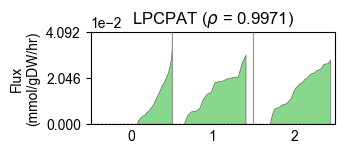

In [128]:
fluxes_to_plot = np.atleast_2d(
    np.array(
        [
            [
                "LPCPAT",
            ],
        ],
    )
)
optimums = [0]
sharex = True
sharey = "row"
supylabel = False
plot_as_bar = False
min_max_norm_flux = False
min_max_norm_abundance = True
include_abundance_line = False
width_scalar = 1
height_scalar = 0.8
fontsizes_dict = dict(
    xlabel=10,
    xticks=10,
    ylabel=10,
    yticks=10,
    title=12,
)
panel_kwargs = dict(
    # Only for bar plot
    width=1,  # Bar width
    linewidth=0.5,  # Edgewidth of bars
    edgecolor="black",  # Color of edge width
    # Both plots
    alpha=0.5,
    zorder=2,
    maxnum_yticks=3,
    # Equilibrium line
    equilibrium_lineprops=dict(
        color="black",
        linestyle=":",
        linewidth=1,
    ),
)
flux_str = "Normalized\nFlux" if min_max_norm_flux else "Flux\n(mmol/gDW/hr)"
abundance_str = (
    "Normalized\nAbundance" if min_max_norm_abundance else "Abundance\n(nmol/gDW)"
)
ordered_model_groups = {
    group: model_groups[group] for group in ordered_groups_to_compare
}
xlabels_dict = {
    group: group.replace(main_group_name, "").strip("_")
    for group in list(ordered_model_groups)
}
ylabels_dict = (
    {reaction: flux_str for reaction in fluxes_to_plot.flatten() if reaction}
    if not supylabel
    else {}
)
ylabels_dict = {}
titles_dict = {
    reaction: reaction
    + (
        " ($\\rho$ = " + "{})".format(round(reaction_correlations[reaction], 4))
        if reaction_correlations and reaction_correlations.get(reaction)
        else ""
    )
    for reaction in fluxes_to_plot.flatten()
    if reaction
}
# titles_dict = {}
fig, all_axes = create_flux_range_figure_axes(
    *fluxes_to_plot.shape,
    len(ordered_model_groups),
    width_scalar=width_scalar,  # * (fluxes_to_plot.shape[0]),
    height_scalar=height_scalar,  # * (fluxes_to_plot.shape[1] + hspace),
    hspace=0.5 if sharex else 1,
    wspace=0.05 if sharey else 0.5,
)

for row_idx, (row_rxns, row_axes) in enumerate(zip(fluxes_to_plot, all_axes)):
    for col_idx, (reaction, axes) in enumerate(zip(row_rxns, row_axes)):
        df_data_reaction = df_data_groups_to_compare.loc[reaction].copy()
        if min_max_norm_flux:
            df_data_reaction["norm_range"] = (
                (df_data_reaction["range"] - df_data_reaction["range"].min())
                / (df_data_reaction["range"].max() - df_data_reaction["range"].min())
            ).fillna(0)
            ylims = (0, 1 + ypad_percent)
        elif sharey:
            rxn_list = row_rxns if sharey == "row" else fluxes_to_plot.flatten()
            df_ylim = df_data_groups_to_compare.loc[[x for x in rxn_list if x]]
            ylims = (
                df_ylim["min"].min() - (df_ylim["min"].min() * ypad_percent),
                df_ylim["max"].max() + (df_ylim["max"].max() * ypad_percent),
            )
        else:
            ylims = (
                df_data_reaction["min"].min()
                - (df_data_reaction["min"].min() * ypad_percent),
                df_data_reaction["max"].max()
                + (df_data_reaction["max"].max() * ypad_percent),
            )
        for panel_idx, ((group, sample_list), ax_panel) in enumerate(
            zip(ordered_model_groups.items(), axes)
        ):
            # Get samples for group and order by donor number
            df_data_group = df_data_reaction.loc[sample_list]
            # Get data for ooptimums
            xlims = (0, len(df_data_group.index.unique()))
            for optimum in optimums:
                df = df_data_group[df_data_group["optimum"] == optimum].drop(
                    "optimum", axis=1
                )
                # Rank order results within the optimum if desired
                df = df.sort_values(
                    by=list(rank_order_results),
                    ascending=(
                        list(rank_order_results.values())
                        if isinstance(rank_order_results, dict)
                        else True
                    ),
                )
                ax_panel = plot_flux_range_panel(
                    x=np.arange(*xlims),
                    min_values=(
                        df["min"].values
                        if not min_max_norm_flux
                        else df["min"].values - df["min"].values
                    ),
                    max_values=(
                        df["max"].values
                        if not min_max_norm_flux
                        else df["norm_range"].values
                    ),
                    ax=ax_panel,
                    bar=plot_as_bar,
                    color=optimum_colors.get(optimum, "xkcd:light green"),
                    **panel_kwargs,
                )

            if include_abundance_line:
                abundance_values = df_data_reaction.groupby(level=0)["abundance"].max()
                if min_max_norm_abundance:
                    abundance_values = (
                        (abundance_values - abundance_values.min())
                        / (abundance_values.max() - abundance_values.min())
                    ).fillna(0)
                    aylims = (0, 1)
                elif sharey:
                    rxn_list = row_rxns if sharey == "row" else fluxes_to_plot.flatten()
                    aylims = (
                        df_data_groups_to_compare.loc[[x for x in rxn_list if x]][
                            "abundance"
                        ].min(),
                        df_data_groups_to_compare.loc[[x for x in rxn_list if x]][
                            "abundance"
                        ].max(),
                    )
                    aylims = (
                        aylims[0] - (aylims[0] * ypad_percent),
                        aylims[1] + (aylims[1] * ypad_percent),
                    )
                else:
                    aylims = (
                        0 - (df_data_reaction["abundance"].max() * ypad_percent),
                        df_data_reaction["abundance"].max()
                        + (df_data_reaction["abundance"].max() * ypad_percent),
                    )

                ax_abundance = plot_abundance_line(
                    x=np.arange(*xlims),
                    y=abundance_values.loc[df.index].copy(),
                    ax=ax_panel.twinx(),
                    xlims=(
                        xlims[0] - panel_kwargs.get("xlim_pad", 1),
                        xlims[1] + panel_kwargs.get("xlim_pad", 1),
                    ),
                    ylims=aylims,
                    **abundance_kwargs,
                )
                if (panel_idx == len(ordered_model_groups) - 1) and (
                    (sharey and col_idx == fluxes_to_plot.shape[1] - 1) or not sharey
                ):
                    ylabel = abundance_str if not supylabel else None
                    if min_max_norm_abundance:
                        ax_abundance.set_yticks(
                            np.linspace(0, 1, panel_kwargs.get("maxnum_yticks", 3))
                        )
                    elif panel_kwargs.get("maxnum_yticks"):
                        ax_abundance.set_yticks(
                            np.linspace(
                                ax_abundance.get_ybound()[0],
                                ax_abundance.get_ybound()[1],
                                panel_kwargs.get("maxnum_yticks", 3),
                            )
                        )
                    ax_abundance.set_ylabel(
                        ylabel,
                        fontsize=fontsizes_dict.get("ylabel", "large"),
                        va="center",
                        labelpad=15,
                        color=abundance_label_color,
                    )
                    ax_abundance.yaxis.set_tick_params(
                        labelsize=fontsizes_dict.get("yticks", "large"),
                        labelright=True,
                        colors=abundance_label_color,
                    )
                else:
                    ax_abundance.set_ylabel(None)
                    ax_abundance.set_yticks([])
                    ax_abundance.yaxis.set_tick_params(labelright=False)

            # Format panel, lot of conditional inputs depending on where panel is and whether multiple rows/columns are present.
            format_panel_for_group(
                ax_panel,
                panel_idx=panel_idx,
                xaxis_dict=dict(
                    # Add extra padding for limits
                    lim=(
                        xlims[0] - panel_kwargs.get("xlim_pad", 1),
                        xlims[1] + panel_kwargs.get("xlim_pad", 1),
                    ),
                    label=(
                        xlabels_dict.get(group)
                        if (
                            (row_idx == fluxes_to_plot.shape[0] - 1 and sharex)
                            or not sharex
                        )
                        else None
                    ),
                ),
                yaxis_dict=dict(
                    lim=ylims,
                    label=(
                        ylabels_dict.get(reaction, flux_str)
                        if (not supylabel and ((col_idx == 0 and sharey) or not sharey))
                        else None
                    ),
                    va="center",
                    labelpad=15,
                    color=flux_label_color if include_abundance_line else "black",
                    maxnum_yticks=panel_kwargs.get("maxnum_yticks", 3),
                    ticklabel_format=dict(style="sci", scilimits=(0, 0)),
                ),
                fontsizes_dict=fontsizes_dict,
                seperator_spine_color="xkcd:grey",
                min_max_norm_flux=min_max_norm_flux,
            )
            if panel_idx == 0 and ((col_idx != 0 and sharey) or not sharey):
                ax_panel.yaxis.set_tick_params(labelleft=False)
            if panel_idx == (len(ordered_model_groups) - 1) / 2 or (
                len(ordered_model_groups) % 2 == 0 and panel_idx % 2 == 0
            ):
                if (
                    panel_idx == (len(ordered_model_groups) - 1) / 2
                ):  # Odd number of panels
                    ax_panel.set_title(
                        titles_dict.get(reaction, reaction),
                        fontsize=fontsizes_dict.get("title", "xx-large"),
                    )
                else:  # Even number of panels
                    ax_panel.text(
                        x=1,
                        y=1.1,
                        s=titles_dict.get(reaction, reaction),
                        transform=ax_panel.transAxes,
                        ha="center",
                    )
if supylabel:
    # Adjust manually
    text = fig.text(
        x=0.02 + 0.025 * fluxes_to_plot.shape[1],
        y=0.5,
        s=flux_str,
        ha="center",
        va="center",
        fontsize=fontsizes_dict.get("supylabel", "xx-large"),
        color=flux_label_color if include_abundance_line else "black",
        rotation="vertical",
    )
    if include_abundance_line:
        fig.text(
            x=1.0 - 0.025 * fluxes_to_plot.shape[1],
            y=0.5,
            s=abundance_str,
            ha="center",
            va="center",
            fontsize=fontsizes_dict.get("supylabel", "xx-large"),
            color=abundance_label_color,
            rotation="vertical",
        )

fig.align_xlabels()
fig.align_ylabels()
plt.show()
if save_figures:
    rxns = "_".join(fluxes_to_plot.flatten())
    fig_dirpath = (
        group_results_dirpath_dict[main_group_name]
        / "fluxranges"
        / "_".join(ordered_groups_to_compare)
    )
    fig_dirpath.mkdir(exist_ok=True, parents=True)
    fig.savefig(
        fig_dirpath / f"fluxes_{rxns}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig